Define all functions
====

In [6]:
import numpy as np
from numpy import pi
from scipy.integrate import ode

mrand=lambda: 2*np.random.rand()-1 # shortcut random number between -1 and 1
def roll(arr,tup):
    '''a shortcut. roll(arr,(S1,S2)) applies roll with S1 steps on 1st axis and then with S2 on the 2nd one'''
    return np.roll(np.roll(arr,tup[0],axis=0),tup[1],axis=1)

def generate_v_field(n=17,max_periods=4):
    '''Generates a random divergence-less velocity field on the periodic domain [0,2*pi]x[0,2*pi].
       n - number of sinusoidal terms
       max_periods - maximal periods each term has over the domain 2pi (large value = high frequency)
    '''
    x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],
                    np.linspace(0,2*pi,N+1)[:-1])
    u=0*x;
    v=0*x;
    for i in xrange(n):
        A=np.random.randn()
        nx=np.round(max_periods*mrand())
        ny=np.round(max_periods*mrand())
        phi=pi*mrand()
        u+=A*ny*np.sin(nx*x+ny*y+phi)
        v-=A*nx*np.sin(nx*x+ny*y+phi)
    return u,v

def velocity_dot_grad_c(u,v,C):
    '''calculates the advective derivative of C with the velocity field (u,v)/
       That is, u dC/dx+v dC/dy'''
    
    return  (
            (0.25/dx)*(
             (C+roll(C,[0,-1]))*(roll(u,[1,-1])+roll(u,[0,-1]))-
             (C+roll(C,[0, 1]))*(roll(u,[0, 0])+roll(u,[1, 0])))+
            (0.25/dx)*(
             (C+roll(C,[-1, 0]))*(roll(v,[0,0])+roll(v,[0,-1]))-
             (C+roll(C,[ 1, 0]))*(roll(v,[1,-1])+roll(v,[1,0])))
            )

def laplacian(C):
    '''calculates the laplacian of C'''
    return (
            roll(C,[-1,0])+roll(C,[0,-1])+roll(C,[1,0])+roll(C,[0,1])-4*C
            )/(dx**2)

def dvdt_maker(u,v,eta,sources):
    '''returns a function that calculates the time derivative but is usable in the integrator that needs a vector
       input rather than a matrix.'''
    return lambda t,C: Cdot(C.reshape(N,N),u,v,eta,sources).flatten()

def Cdot(C,u,v,eta,sources):
    '''Returns the time derivative of the concentration field C, under diffusion and advection
       C        - concentration field
       (u,v)    - components of velocity field
       eta      - diffusion constant
       sources  - sources (and sinks)'''
    return -velocity_dot_grad_c(u,v,C)+eta*laplacian(C)+sources

def point_sources():
    z=np.zeros([N,N])
    z[np.round(N/4),np.round(N/4)]=1
    z[np.round(3*N/4),np.round(3*N/4)]=-1
    return z

def gauss_sources(width=0.2,randomize_positions=False):
    x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],
                np.linspace(0,2*pi,N+1)[:-1])
    q=np.exp(-((x-pi)/width)**2-((y-pi)/width)**2)

    if randomize_positions:
        return roll(q,[int(N*mrand()) for i in [1,2]])-roll(q,[int(N*mrand()) for i in [1,2]])
    else:
        return roll(q,[N/4,N/4])-roll(q,[-N/4,-N/4])

def calculate_steady_plume(eta,
                           number_of_points=200,
                           tolerance=1.0e-8,
                           max_iterations=100,
                           verbose=False,
                           width=0.2,
                           randomize_positions=False):
    '''
        Calculates a steady plume in a divergenceless field. 
        Returns (c,u,v,sources,flag):
            c       - the steady concentration field
            (u, v)  - the velocity field
            sources - the sources and sinks in the equation
            flag    - True if the solution is steady to within the tolerance
        Arguments:
            eta                 - diffusion constant
            number_of_points    - in each dimension (result is an NxN matrix)
            width               - width of the gaussian sources
            randomize_positions - whether to choose the positions of the source and sink randomly
                                  if False, they are at the middle of the top-right and bottom-left quartiles
            verbose             - whether to print progress in each iteration
            
    '''
    global dx, N
    N=number_of_points
    dx=2*pi/N
    u,v=generate_v_field()
    sources=gauss_sources(randomize_positions=randomize_positions,width=width)
    fdot=dvdt_maker(u,v,eta,sources)
    
    solver=ode(fdot).set_integrator('dopri5')
    solver.set_initial_value(0*u.flatten())
    i=0;
    prev=np.zeros(N*N);
    error=1
    while solver.successful() and i<max_iterations and error > tolerance:
        solver.integrate(solver.t+1)
        error=np.max(np.abs(solver.y-prev))
        prev=solver.y
        i+=1
        if verbose:
            print 'step %d, error=%e' %(i, error)
    return ( solver.y.reshape(N,N), u, v,  sources, error<tolerance )

Demo: calculate field
==

In [18]:
(c,u,v,sources,flag)=calculate_steady_plume(0.1,number_of_points=200,verbose=True,tolerance=1e-4)

step 1, error=1.601604e-01
step 2, error=3.226240e-02
step 3, error=8.844969e-03
step 4, error=2.890467e-03
step 5, error=1.364708e-03
step 6, error=6.443242e-04
step 7, error=3.025691e-04
step 8, error=1.461495e-04
step 9, error=7.166080e-05


Plot results
---

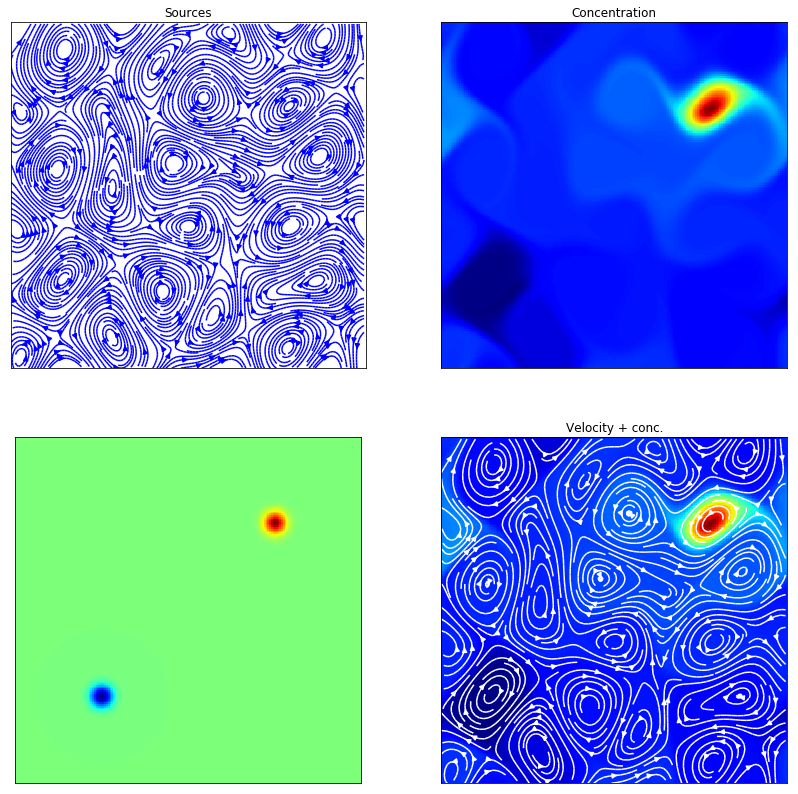

In [20]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],
                    np.linspace(0,2*pi,N+1)[:-1])
fig , axs= plt.subplots(nrows=2,ncols=2,figsize=(14,14))
axs[0,0].streamplot(N*x/(2*pi),N*y/(2*pi),u,v,color='b',density=4)
axs[0,0].set_title('Velocity')
axs[0,1].imshow(c,cmap=plt.get_cmap('jet'))
axs[0,1].set_title('Concentration')
axs[1,0].imshow(sources,cmap=plt.get_cmap('jet'))
axs[0,0].set_title('Sources')
axs[1,1].imshow(c,cmap=plt.get_cmap('jet'))
axs[1,1].streamplot(N*x/(2*pi),N*y/(2*pi),u,v,color='w',density=2)
axs[1,1].set_title('Velocity + conc.')
for ax in axs.flatten():
    ax.set_xlim([0,N])
    ax.set_ylim([0,N])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()